In [296]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [297]:
fcs =  [round(i*0.04,2) for i in range(20)]


In [298]:

import pandas as pd
import numpy as np

from scipy import stats

import os 

os.chdir("/home/ptruong/git/dia_sum/scripts/PXD002952")

from q_value import qvalues
from triqler_output_to_df import  parse_triqler
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run")



# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]
def decoy_mapper(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False
    
def read_in_and_filter(filename, m_score_treshold = 0.01):  
    print(filename)
    df = pd.read_csv(filename, sep = "\t")
    df = df[df.decoy != 1]
    df = df[df.m_score < m_score_treshold] # filter away crap, so all values should be good... we take average of top3 here
    print(str(len(df)) + " significantly identified peptides at " + str(m_score_treshold) + " FDR-treshold.")
    print("")
    df["experiment_id"] = df["filename"].map(experiment_id_mapper)
    df["sample_id"] = df["filename"].map(sample_id_mapper)
    sample_id = df.sample_id.unique()[0]
    experiment_id = df.experiment_id.unique()[0]     
    def top3(df):
        df = (df.groupby('ProteinName')['Intensity'].apply(lambda x: x.nlargest(3).mean() if len(x.nlargest(3)) >= 2 else np.nan)
                  .reset_index())
        #print(df.isna().sum())
        return df
    df_reduced = df[["ProteinName", "Intensity"]]
    df_protein = top3(df_reduced)
    df = df_protein
    df["specie"] = df.ProteinName.map(specie_mapper)
    midx = pd.MultiIndex(levels = [[sample_id],[experiment_id]], codes = [[0],[0]], names = ["sample_id", "experiment_id"])
    df = df.set_index(["specie", "ProteinName"])
    df = pd.DataFrame(df.values, columns = midx, index = df.index)
    
    return df



# highest scoring vs top highest intenstiy peptide?
# We take top3 intensity because we filter away so much with m_score < 0.01, all values should be good.

dfs = []
for file in os.listdir():
    if file[-10:] == "dscore.csv":
        dfs.append(read_in_and_filter(file, m_score_treshold=0.01))
        #print(len(df_part))
        #df = pd.concat([df, df_part],axis = 1)        
df = pd.concat(dfs, axis = 1)

df["decoy"] = df.index.get_level_values("ProteinName").map(decoy_mapper) 
df.decoy.sum()

A = df[df.iloc[:, df.columns.get_level_values("sample_id") == "1"].isna().sum(axis=1)<2]
A = A.iloc[:,A.columns.get_level_values("sample_id") == "1"]
#A = np.log2(A)
B = df[df.iloc[:, df.columns.get_level_values("sample_id") == "2"].isna().sum(axis=1)<2]
B = B.iloc[:,B.columns.get_level_values("sample_id") == "2"]
#B = np.log2(B)

# Find overlapping proteins
overlapping_proteins = list(set(A.index) & set(B.index))
A = A[A.index.isin(overlapping_proteins)]
B = B[B.index.isin(overlapping_proteins)]





import scipy.stats as stats

p_vals = stats.ttest_ind(A, B, axis = 1)[1]
p_vals = pd.DataFrame(p_vals, columns = ["p"])
p_vals["q"] = qvalues(p_vals)
p_vals = pd.DataFrame(p_vals.values, index = A.index, columns = ["p", "q"])
p_vals.sort_values("q",inplace =True)
p_vals = p_vals.astype(float)

A = np.log2(A.sum(axis=1))
B = np.log2(B.sum(axis=1))

A.name = "1"
B.name = "2"

df_final = pd.concat([A, B, p_vals], axis = 1)
df_final["log2(A,B)"] = df_final["1"] - df_final["2"]

def pq_data(df_final, fc_treshold):
    # two-side treshold because triqler uses two side treshold.
    df_final_fc_gt = (df_final[df_final["log2(A,B)"] > fc_treshold])
    df_final_fc_lt = (df_final[df_final["log2(A,B)"] < -fc_treshold])
    df_final_fc = pd.concat([df_final_fc_gt, df_final_fc_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (df_final_fc["q"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

# test
#pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = 0.2)
#pq_data(df_final[df_final.index.get_level_values("specie") == "YEAS8"], fc_treshold = 0.2)
#pq_data(df_final[df_final.index.get_level_values("specie") == "ECOLI"], fc_treshold = 0.2)


import matplotlib.pyplot as plt

specie = "HUMAN"

def plot_pq(df_final, specie):
    fig, axs = plt.subplots(2, 5)
    row = 0
    col = 0
    for i in range(10):
        fc =i*0.2
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
        if i == 0:
            y_lim = df.max()[0]
        axs[row, col].plot(df.index, df.DE)
        axs[row, col].set_ylim([0, y_lim])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col += 1
        if col == 5:
            row +=1
            col = 0
    plt.suptitle("OSW top3 " + specie)
    plt.show()




osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_003-Pedro_-_Sample_2_-_SW32_-_Repl1.mzML_with_dscore.csv
20494 significantly identified peptides at 0.01 FDR-treshold.

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_007-Pedro_-_Sample_2_-_SW32_-_Repl3.mzML_with_dscore.csv
22787 significantly identified peptides at 0.01 FDR-treshold.

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_002-Pedro_-_Sample_1_-_SW32_-_Repl1.mzML_with_dscore.csv
20747 significantly identified peptides at 0.01 FDR-treshold.

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_005-Pedro_-_Sample_2_-_SW32_-_Repl2.mzML_with_dscore.csv
22792 significantly identified peptides at 0.01 FDR-treshold.

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_004-Pedro_-_Sample_1_-_SW32_-_Repl2.mzML_with_dscore.csv
21445 significantly identified peptides at 0.01 FDR-treshold.

osw_output.HYE124_TTOF6600_32fix_lgillet_I150211_006-Pedro_-_Sample_1_-_SW32_-_Repl3.mzML_with_dscore.csv
21016 significantly identified peptides at 0.01 F

/home/ptruong/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/ptruong/git/dia_sum/scripts/PXD002952/q_value.py:21: RuntimeWarning: invalid value encountered in less_equal
  Wls = np.array([n-np.argmax(p>=l) for l in lambdas])
/home/ptruong/git/dia_sum/scripts/PXD002952/q_value.py:28: RuntimeWarning: invalid value encountered in less_equal
  WlsBoot =np.array([n-np.argmax(pBoot>=l) for l in lambdas])


In [299]:

import time
from triqler_output_to_df import  parse_triqler
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/triqler_results")

def get_pq_data_triqler(q_val):
    fc_tresh = []
    n_hs = []
    n_ye = []
    n_ec = []
    
    for file in sorted(os.listdir()):       
        fc = float(file.split("_")[1])
        df_triq = parse_triqler(file)
        df_triq = df_triq[df_triq.q_value < q_val]
        df_triq["specie"] = df_triq.protein.map(specie_mapper)
        n_hs.append((df_triq["specie"] == "HUMAN").sum())
        n_ye.append((df_triq["specie"] == "YEAST").sum())
        n_ec.append((df_triq["specie"] == "ECOLI").sum())
        fc_tresh.append(fc)
    
    df =pd.DataFrame(np.array([n_hs, n_ye, n_ec]).T, index = fc_tresh, columns = ["HUMAN", "YEAST", "ECOLI"])
    return df

def map_decoy(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False

#start = time.time()
def get_DE_for_fcs(fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    qs = []
    dfs = []
    for q in np.arange(0,0.101, 0.001):
        qs.append(q)
        dfs.append(get_pq_data_triqler(q))
        #print(time.time()-start)
    end = time.time()
    #print(end-start)
    
    fcs = fcs
    fcs.sort()
    res = []
    for fc in fcs:
        vals = []
        for df in dfs:
            val = list(df[df.index == fc].values[0])
            vals.append(val)    
        df_res = pd.DataFrame(vals, index = np.arange(0,0.101, 0.001), columns = ["HUMAN", "YEAST", "ECOLI"])
        res.append(df_res)
    return res

res = get_DE_for_fcs( fcs = fcs)



def msstats_pq_data(ms, fc):
    # ms = pd.read_csv("msstats.csv")
    ms_gt = ms[ms.log2FC > fc]
    ms_lt = ms[ms.log2FC < -fc]
    ms_fc = pd.concat([ms_gt, ms_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (ms_fc["adj.pvalue"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

# MSSTATS
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/msstats_results")

ms = pd.read_csv("msstats_output_filtered.csv")
ms["specie"] = ms.Protein.map(specie_mapper)

ms[ms.specie == "YEAS8"]

#Rewrite this to function subplot
def plot_pq_specie(specie):
    fig, axs = plt.subplots(2, 5)
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = [round(i*0.2,2) for i in range(9)] + [0.68]
    fcs.sort()
    for i in range(10):
        fc = fcs[i]
        res[i][specie].plot(ax = axs[row,col]) #triqler data plot
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
        df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
        axs[row, col].plot(df.index, df.DE) # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()


#os.chdir("/home/ptruong/git/MSqRobSum/inst/extdata")
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/msrobsum_results")

msqrob = pd.read_csv("msqrobsum_result.csv", sep = "\t")
msqrob["specie"] = msqrob.proteins.map(specie_mapper)

msqrob

def msqrob_pq_data(msqrob, fc):
    msqrob_gt = msqrob[msqrob.logFC > fc]
    msqrob_lt = msqrob[msqrob.logFC < -fc]
    msqrob_fc = pd.concat([msqrob_gt, msqrob_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (msqrob_fc["qvalue"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

#msqrob_pq_data(msqrob, fc = 0.2)

In [300]:
fcs[10]

0.4

In [301]:
def plot_pq_specie(specie, fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        if specie == "all":
            res[i].sum(axis=1).plot(ax = axs[row,col]) #triqler data plot
            df = pq_data(df_final, fc_treshold = fc)
            df_ms = msstats_pq_data(ms, fc = fc)
            df_msqrob = msqrob_pq_data(msqrob, fc = fc)
        else:
            res[i][specie].plot(ax = axs[row,col]) #triqler data plot
            df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
            df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
            df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc)
        axs[row, col].plot(df.index, df.DE) # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()




## N-differentially expressed proteins

This is used to show number of differentially expresed proteins

Text(0.5, 0.98, 'Differentially expressed protein (OpenSwath)')

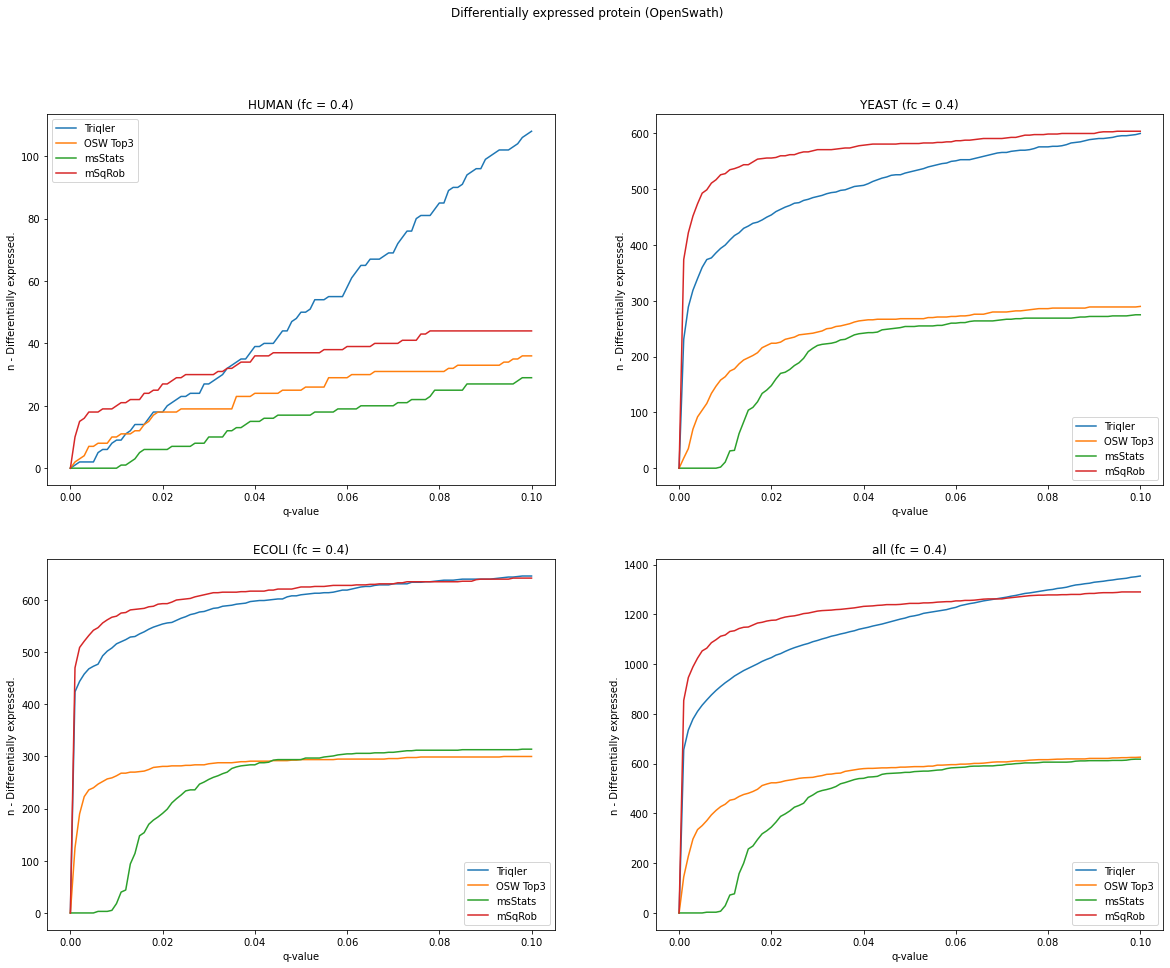

In [302]:
row = 0
col = 0

fig, axs = plt.subplots(2,2, figsize = (20,15))
fc = 0.4

def plot_pq(specie, row, col):
    triq = res[10] # fcs[10] is 0.4 in this case
    
    if specie == "all":
        df = pq_data(df_final, fc_treshold = 0.4)
        #df_triq = res[i].sum(axis=1)
        df_ms = msstats_pq_data(ms, fc = 0.4)
        df_msqrob = msqrob_pq_data(msqrob, fc = 0.4)
        triq.sum(axis=1).plot(ax = axs[row,col])

    else:
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = 0.4)
        df_ms = msstats_pq_data(ms[ms.specie == specie], fc = 0.4)
        df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = 0.4)
        triq[specie].plot(ax = axs[row,col])
    
    axs[row, col].plot(df.index, df.DE) # plot osw top3
    axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
    axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
    axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
    axs[row, col].set_title(f"{specie} (fc = {0.4})")
    axs[row, col].set_xlabel("q-value")
    axs[row, col].set_ylabel("n - Differentially expressed.")
    
plot_pq("HUMAN", row = 0, col = 0)
plot_pq("YEAST", row = 0, col = 1)
plot_pq("ECOLI", row = 1, col = 0)
plot_pq("all", row = 1, col = 1)
plt.suptitle("Differentially expressed protein (OpenSwath)")


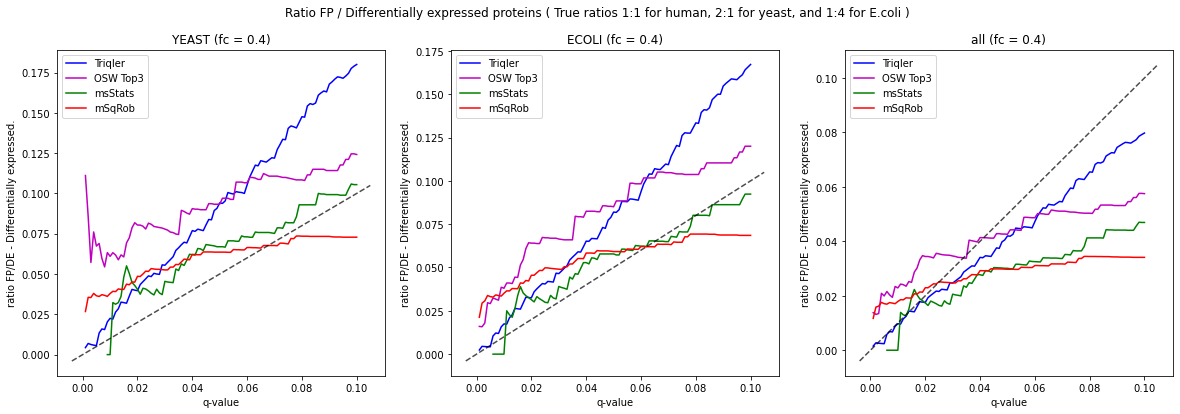

In [303]:
fig, axs = plt.subplots(1, 3, figsize=(20,6))
fc = 0.4
#Rewrite this to function subplot

def plot_ratio_FP_DE(specie,col):


    if specie == "all":
        df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
              pq_data(df_final, fc_treshold = fc))
        df_triq = (res[10]["HUMAN"] / 
                   res[10].sum(axis=1))
        df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                 msstats_pq_data(ms, fc = fc))
        df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                     msqrob_pq_data(msqrob, fc = fc))        
    else:
        df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
              pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc))
        df_triq = (res[10]["HUMAN"] / 
                   res[10][specie])
        df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                 msstats_pq_data(ms[ms.specie == specie], fc = fc))
        df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                     msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc))        

    df_triq.plot(ax = axs[col], style = "b") # triqler data plot
    axs[col].plot(df.index, df.DE, "m") # plot osw top3
    axs[col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
    axs[col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob

    axs[col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
    axs[col].set_title(f"{specie} (fc = {fc})")
    axs[col].set_xlabel("q-value")
    axs[col].set_ylabel("ratio FP/DE - Differentially expressed.")

    def abline(slope, intercept, col):
        """Plot a line from slope and intercept"""
        axes = plt.gca()
        x_vals = np.array(axs[col].get_xlim())
        y_vals = intercept + slope * x_vals
        axs[col].plot(x_vals, y_vals, 'k--', alpha = 0.7)
    abline(1,0,col)

plot_ratio_FP_DE("YEAST", 0,)
plot_ratio_FP_DE("ECOLI", 1)
plot_ratio_FP_DE("all", 2)
    
plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
plt.show()


# Protein quantity distributions
This is used to show how the data looks

In [304]:
import seaborn as sns

Text(0.5, 0.98, 'Triqler log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

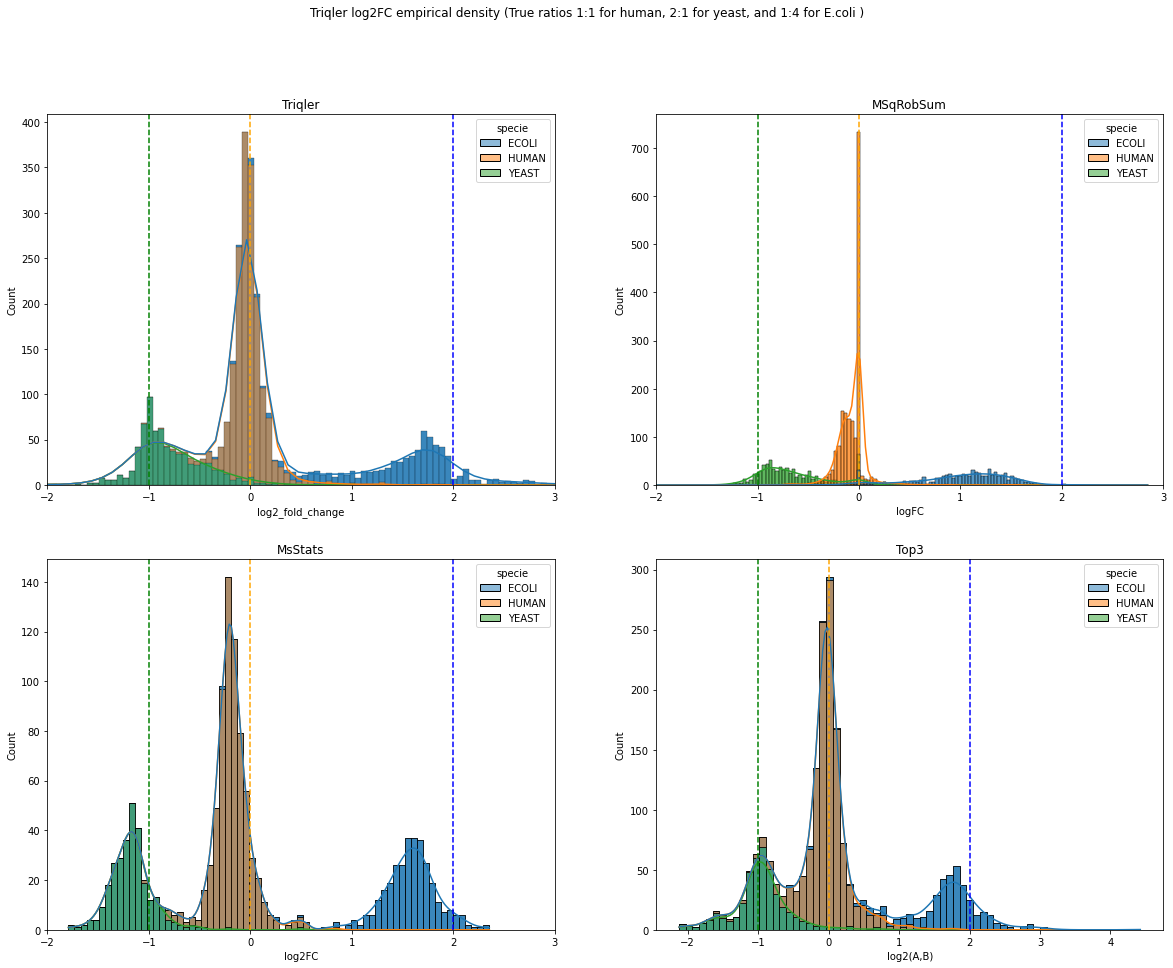

In [305]:
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/triqler_results")
q_val = 1
file = "fc_0.40"
df_triq = parse_triqler(file)
df_triq["decoy"] = df_triq.protein.map(decoy_mapper)
df_triq = df_triq[df_triq.decoy == False] # remove decoy proteins.
df_triq = df_triq[df_triq.q_value < q_val]
df_triq["specie"] = df_triq.protein.map(specie_mapper)
df_triq.sort_values(by = "specie", inplace = True)
df_triq.log2_fold_change = -df_triq.log2_fold_change

fig, axs = plt.subplots(2, 2, figsize=(20,15))

sns.histplot(df_triq["log2_fold_change"], kde = False, ax = axs[0,0])
sns.histplot(data=df_triq, x="log2_fold_change", hue="specie", multiple="stack", kde = True, ax = axs[0,0])
axs[0,0].set_xlim([-2, 3])
axs[0,0].set_title("Triqler")

axs[0,0].axvline(x = 0, color = "orange", linestyle = "--")
axs[0,0].axvline(x = -1, color = "green", linestyle = "--")
axs[0,0].axvline(x = 2, color = "blue", linestyle = "--")


msqrob.sort_values(by = "specie", inplace = True )
msqrob["specie"] = msqrob.proteins.map(specie_mapper)
sns.histplot(msqrob, x = "logFC", hue = "specie",kde = True, ax = axs[0,1])
sns.histplot(msqrob, x = "logFC", hue = "specie",kde = False, ax = axs[0,1])
axs[0,1].set_title("MSqRobSum")
axs[0,1].set_xlim([-2, 3])

axs[0,1].axvline(x = 0, color = "orange", linestyle = "--")
axs[0,1].axvline(x = -1, color = "green", linestyle = "--")
axs[0,1].axvline(x = 2, color = "blue", linestyle = "--")


ms.sort_values(by = "specie", inplace = True )
sns.histplot(ms.log2FC, kde = False, ax = axs[1,0], bins = 70)
sns.histplot(data=ms, x="log2FC", hue="specie", multiple="stack", bins = 70, kde = True, ax = axs[1,0])
axs[1,0].set_title("MsStats")
axs[1,0].set_xlim([-2, 3])


axs[1,0].axvline(x = 0, color = "orange", linestyle = "--")
axs[1,0].axvline(x = -1, color = "green", linestyle = "--")
axs[1,0].axvline(x = 2, color = "blue", linestyle = "--")

# add -1* to reverse histograms
sns.histplot(-1*df_final["log2(A,B)"], kde = False, ax = axs[1,1])
axs[1,1].set_title("Top3")
sns.histplot(data=-1*df_final, x="log2(A,B)", hue="specie", multiple="stack", kde = True)

axs[1,1].axvline(x = 0, color = "orange", linestyle = "--")
axs[1,1].axvline(x = -1, color = "green", linestyle = "--")
axs[1,1].axvline(x = 2, color = "blue", linestyle = "--")


fig.suptitle('Triqler log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

# Variance distribution
Used to show that the variance of intensity increases linearily as the intensity get highers.

In [306]:
from q_value import qvalues
from triqler_output_to_df import  parse_triqler
os.chdir("/hdd_14T/data/PXD002952/osw_res_20210303/hye124/ttof6600/32fix/full_ts_v")
#os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run")

# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]

def read_in_and_filter(filename, m_score_treshold = 0.01):  
    print(filename)
    df = pd.read_csv(filename, sep = "\t")
    df = df[df.decoy != 1]
    df = df[df.m_score < m_score_treshold] # filter away crap, so all values should be good... we take average of top3 here
    print(str(len(df)) + " significantly identified peptides at " + str(m_score_treshold) + " FDR-treshold.")
    print("")
    df["experiment_id"] = df["filename"].map(experiment_id_mapper)
    df["sample_id"] = df["filename"].map(sample_id_mapper)
    sample_id = df.sample_id.iloc[0]
    experiment_id = df.experiment_id.iloc[0]     

    #midx = pd.MultiIndex(levels = [[sample_id],[experiment_id]], codes = [[0],[0]], names = ["sample_id", "experiment_id"])
    df["specie"] = df["ProteinName"].map(specie_mapper)
    df = df.set_index(["specie", "ProteinName", "FullPeptideName", "sample_id", "experiment_id"])
    df = df[["Intensity"]]
    df = pd.DataFrame(df.values, index = df.index)
    
    return df


dfs = []
for file in os.listdir():
    if file[-10:] == "dscore.csv":
        dfs.append(read_in_and_filter(file, m_score_treshold=0.01))
        #print(len(df_part))
        #df = pd.concat([df, df_part],axis = 1)        

df = pd.concat(dfs, axis = 0)
df = np.log2(df)


import matplotlib.pyplot as plt
import seaborn as sns 

def get_peptide_mu_sigma(df):
    df_means = df.groupby(df.index.get_level_values("FullPeptideName")).mean()
    
    df_stat = pd.DataFrame(df_means.values, index = df_means.index, columns = ["mu"])
    df_stat["std"] = df.groupby(df.index.get_level_values("FullPeptideName")).std()
    df_stat["std/mu-ratio"] = df_stat["std"] / df_stat["mu"]
    return df_stat

def select_specie_and_sample(df, specie = "HUMAN", sample = "1"):
    return df.iloc[(df.index.get_level_values("specie") == specie) & (df.index.get_level_values("sample_id") == sample), :]



ValueError: No objects to concatenate

In [ ]:

f, ax = plt.subplots(1, 1, figsize = (15,8))
sns.scatterplot(ax = ax, data = get_peptide_mu_sigma(select_specie_and_sample(df, specie = "HUMAN", sample = "1")), x = "mu", y = "std/mu-ratio", alpha = 0.3)
sns.scatterplot(ax = ax, data = get_peptide_mu_sigma(select_specie_and_sample(df, specie = "YEAS8", sample = "1")), x = "mu", y = "std/mu-ratio", alpha = 0.3)
sns.scatterplot(ax = ax, data = get_peptide_mu_sigma(select_specie_and_sample(df, specie = "ECOLI", sample = "1")), x = "mu", y = "std/mu-ratio", alpha = 0.3)
sns.scatterplot(ax = ax, data = get_peptide_mu_sigma(select_specie_and_sample(df, specie = "HUMAN", sample = "2")), x = "mu", y = "std/mu-ratio", alpha = 0.3)
sns.scatterplot(ax = ax, data = get_peptide_mu_sigma(select_specie_and_sample(df, specie = "YEAS8", sample = "2")), x = "mu", y = "std/mu-ratio", alpha = 0.3)
sns.scatterplot(ax = ax, data = get_peptide_mu_sigma(select_specie_and_sample(df, specie = "ECOLI", sample = "2")), x = "mu", y = "std/mu-ratio", alpha = 0.3)
plt.legend(labels=['HUMAN (sample 1)', 'YEAST (sample 1)', "ECOLI (sample 1)", "HUMAN (sample 2)", "YEAST (sample 2)", "ECOLI (sample 2)"])
plt.title("std/mu ratio for log-transformed peptide values")

# DE specie vs DE human

This plot shows how many true positives we get compares to false positives.

Text(0.5, 0.98, 'Differentially expressed proteins specie to human ratio')

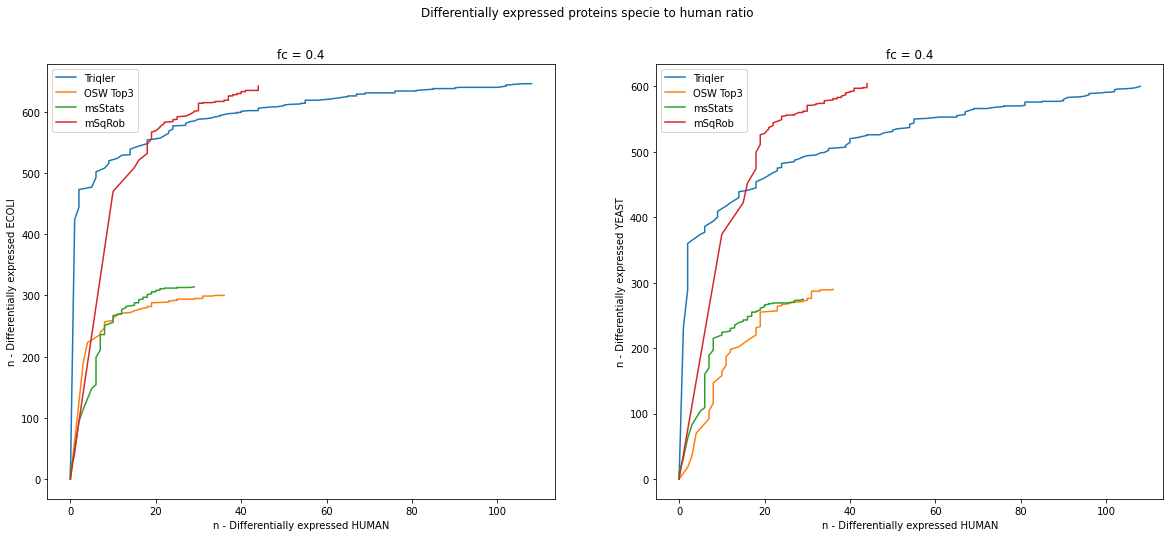

In [307]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
fc = 0.4 
#Rewrite this to function subplot

def plot_de_specie_xy(specie_x, specie_y, ax_n):
    df_triq_x = res[10][specie_x]
    df_x = pq_data(df_final[df_final.index.get_level_values("specie") == specie_x], fc_treshold = fc)
    df_ms_x = msstats_pq_data(ms[ms.specie == specie_x], fc = fc)
    df_msqrob_x = msqrob_pq_data(msqrob[msqrob.specie == specie_x], fc = fc)

    df_triq_y = res[10][specie_y]
    df_y = pq_data(df_final[df_final.index.get_level_values("specie") == specie_y], fc_treshold = fc)
    df_ms_y = msstats_pq_data(ms[ms.specie == specie_y], fc = fc)
    df_msqrob_y = msqrob_pq_data(msqrob[msqrob.specie == specie_y], fc = fc)

    #df_triq_x.plot(ax = axs[row,col]) #triqler data plot        
    #axs[row, col].plot(df.index, df.DE) # plot osw top3
    #axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
    #axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob

    axs[ax_n].plot(df_triq_x.values, df_triq_y.values)
    axs[ax_n].plot(df_x.values, df_y.values)
    axs[ax_n].plot(df_ms_x.values, df_ms_y.values)
    axs[ax_n].plot(df_msqrob_x.values, df_msqrob_y.values)

    axs[ax_n].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
    axs[ax_n].set_title(f"fc = {fc}")
    axs[ax_n].set_xlabel(f"n - Differentially expressed {specie_x}")
    axs[ax_n].set_ylabel(f"n - Differentially expressed {specie_y}")


plot_de_specie_xy(specie_x = "HUMAN", specie_y = "ECOLI", ax_n = 0)
plot_de_specie_xy(specie_x = "HUMAN", specie_y = "YEAST", ax_n = 1)

plt.suptitle(f"Differentially expressed proteins specie to human ratio")# + specie)
#plt.show()


# LFQ Scatter plot



In [308]:
df_final["log2(A)"] = df_final["1"] #log(A)
df_final["log2(B)"] = df_final["2"] #log(A)

In [309]:
df_final["1"] - df_final["2"] #log(A/B)


specie  ProteinName 
ECOLI   P00350_ECOLI   -1.368343
        P00363_ECOLI   -1.558344
        P00393_ECOLI   -2.579503
        P00490_ECOLI   -1.180409
        P00550_ECOLI   -2.227466
                          ...   
YEAST   Q12522_YEAST    0.976493
        Q12746_YEAST    0.444412
        Q96VH4_YEAST    1.134555
        Q99258_YEAST    1.564289
        Q99383_YEAST    0.854197
Length: 2029, dtype: float64

Text(0.5, 1.0, 'std/mu ratio for log-transformed peptide values')

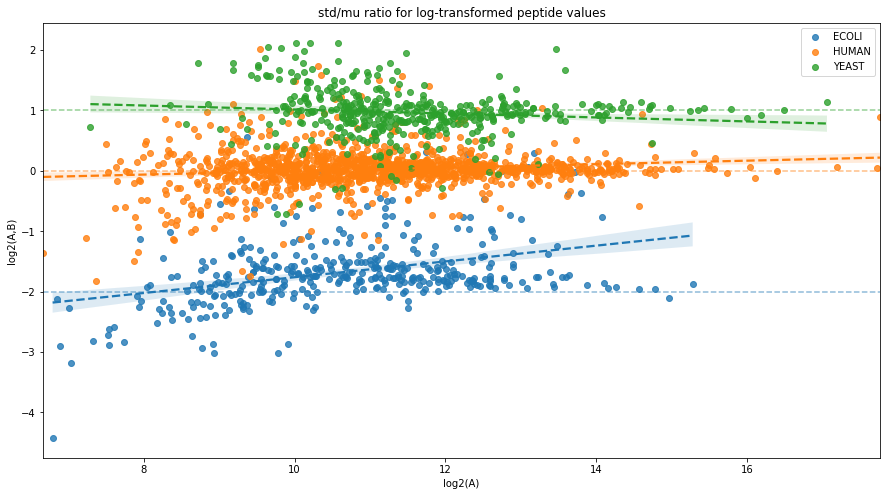

In [310]:

f, ax = plt.subplots(1, 1, figsize = (15,8))
#sns.scatterplot(ax = ax, data = df_final, x = "log2(B)", y = "log2(A,B)", alpha = 0.7, hue = "specie")
df_final["specie"] = df_final.index.get_level_values("specie")
sns.regplot(data = df_final[df_final.specie == "ECOLI"], x = "log2(A)", y = "log2(A,B)", ax = ax, line_kws = {"ls":"--"}, label ="ECOLI")
sns.regplot(data = df_final[df_final.specie == "HUMAN"], x = "log2(A)", y = "log2(A,B)", ax = ax, line_kws = {"ls":"--"}, label = "HUMAN")
sns.regplot(data = df_final[df_final.specie == "YEAST"], x = "log2(A)", y = "log2(A,B)", ax = ax, line_kws = {"ls":"--"}, label = "YEAST")
ax.legend()
ax.axhline(1, linestyle = "--", color="tab:green", alpha = 0.5)
ax.axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax.axhline(-2, linestyle = "--", color="tab:blue", alpha = 0.5)
#ax.grid()
#plt.legend(labels=['HUMAN (sample 1)', 'YEAST (sample 1)', "ECOLI (sample 1)", "HUMAN (sample 2)", "YEAST (sample 2)", "ECOLI (sample 2)"])
plt.title("std/mu ratio for log-transformed peptide values")

In [311]:
df_triq["log2(mu_sample1)"] = np.log2(df_triq[["1:002-Pedro", "1:004-Pedro", "1:006-Pedro"]].mean(axis = 1))
df_triq["log2(mu_sample2)"] = np.log2(df_triq[["2:003-Pedro", "2:005-Pedro", "2:007-Pedro"]].mean(axis = 1))
df_triq["log2(median_sample1)"] = np.log2(df_triq[["1:002-Pedro", "1:004-Pedro", "1:006-Pedro"]].median(axis = 1))
df_triq["log2(median_sample2)"] = np.log2(df_triq[["2:003-Pedro", "2:005-Pedro", "2:007-Pedro"]].median(axis = 1))
df_triq["log2(mu_sample1-mu_sample2)"] = (df_triq["log2(mu_sample1)"] - df_triq["log2(mu_sample2)"])


In [312]:
df_triq["mu_sample1"] = df_triq[["1:002-Pedro", "1:004-Pedro", "1:006-Pedro"]].mean(axis = 1)
df_triq["mu_sample2"] = df_triq[["2:003-Pedro", "2:005-Pedro", "2:007-Pedro"]].mean(axis = 1)
df_triq["log2FC"] = (df_triq["mu_sample1"] - df_triq["mu_sample2"])
df_triq["-log2_fold_change"] = -1* df_triq["log2_fold_change"]

(0.0, 5.0)

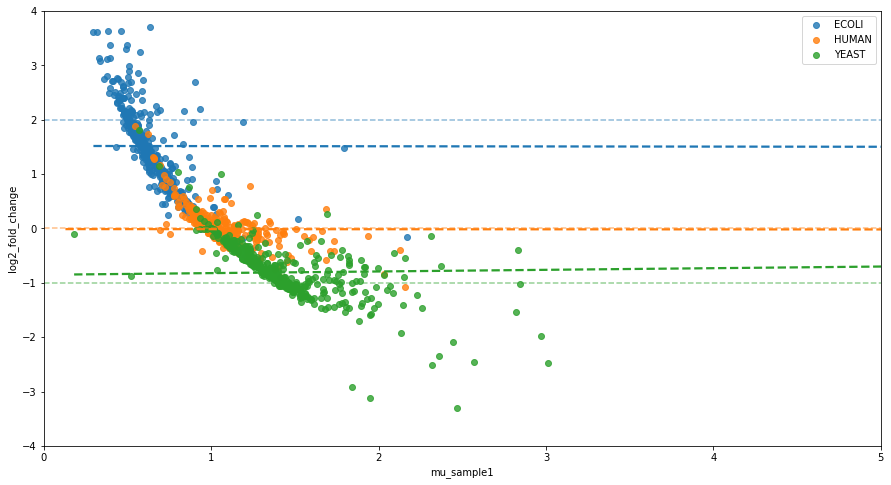

In [313]:

f, ax = plt.subplots(1, 1, figsize = (15,8))
#sns.scatterplot(ax = ax, data = df_triq, x = "log2(mu_sample2)", y = "log2_fold_change", alpha = 0.7, hue = "specie")
sns.regplot(data = 1*df_triq[df_triq.specie == "ECOLI"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "HUMAN"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "YEAST"], x = "mu_sample1", y = "log2_fold_change", ax = ax, line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax.legend()
ax.axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax.axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax.axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
ax.set_ylim([-4, 4])
ax.set_xlim([0, 5])

In [314]:
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/msrobsum_results")
msrob_protein = pd.read_csv("msqrobsum_protein_sum_20210817.csv", sep = "\t")
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/msstats_results")
msstat_protein = pd.read_csv("msstat_output_runleveldata.csv", sep = ",")
msstat_run = pd.read_csv("msstats_run.csv", sep = ",")

In [315]:
msrob_protein["sample"].unique()

array(['X003.Pedro', 'X007.Pedro', 'X002.Pedro', 'X005.Pedro',
       'X004.Pedro', 'X006.Pedro'], dtype=object)

In [316]:
msstat_protein.RUN.unique()

array([1, 2, 3, 4, 5, 6])

In [317]:
run_to_replicate_mapper = dict(msstat_run[["Run","BioReplicate"]].values)
run_to_condition_mapper = dict(msstat_run[["Run", "Condition"]].values)

In [318]:
msstat_protein["replicate"] = msstat_protein.RUN.map(run_to_replicate_mapper)
msstat_protein["condition"] = msstat_protein.RUN.map(run_to_condition_mapper)

In [319]:
msrob_protein_sum = msrob_protein.groupby(["proteins", "condition"]).mean()

In [320]:
msrob_sample1 = msrob_protein_sum[msrob_protein_sum.index.get_level_values("condition") == 1].expression.droplevel("condition")
msrob_sample2 = msrob_protein_sum[msrob_protein_sum.index.get_level_values("condition") == 2].expression.droplevel("condition")

#msrob_log2 = np.log2(msrob_sample1) - np.log2(msrob_sample2)
#msrob_log2 = np.log2(msrob_sample2) - np.log2(msrob_sample1)
msrob_log2 = msrob_sample2 - msrob_sample1

In [321]:
msqrob 

,proteins,human,ecoli,yeas8,contrast,logFC,sigma_contrast,se,t,pvalue,qvalue,specie
1310,P0A8R0_ECOLI,False,True,False,condition2-condition1,1.021772,0.814889,0.065550,15.587739,7.996712e-06,0.000063,ECOLI
638,P0AEP3_ECOLI,False,True,False,condition2-condition1,1.108489,0.809859,0.125745,8.815386,1.713354e-04,0.000696,ECOLI
1254,P21367_ECOLI,False,True,False,condition2-condition1,1.605611,0.816188,0.052398,30.642725,1.914415e-07,0.000013,ECOLI
2002,P25714_ECOLI,False,True,False,condition2-condition1,0.841233,0.814476,0.062135,13.538720,1.725685e-05,0.000112,ECOLI
641,P07118_ECOLI,False,True,False,condition2-condition1,1.211239,0.815869,0.054444,22.247355,1.130537e-06,0.000022,ECOLI
...,...,...,...,...,...,...,...,...,...,...,...,...
2401,P38922_YEAST,False,False,True,condition2-condition1,-0.278456,0.766645,0.093182,-2.988297,2.589341e-02,0.054465,YEAST
837,P38219_YEAST,False,False,True,condition2-condition1,-1.040161,0.816047,0.046924,-22.167042,1.154327e-06,0.000022,YEAST
836,P38999_YEAST,False,False,True,condition2-condition1,-0.683832,0.814191,0.056921,-12.013797,3.305258e-05,0.000182,YEAST
2410,Q12068_YEAST,False,False,True,condition2-condition1,-1.025770,0.810721,0.110107,-9.316140,1.279288e-04,0.000550,YEAST


In [322]:
msrob_sample1.name = "sample1"
msrob_sample2.name = "sample2"
msrob_log2.name = "log2FC"

In [323]:
msrob_df = pd.concat([msrob_sample1, msrob_sample2, msrob_log2], axis = 1)
species_mapper = lambda x: x.split("_")[-1]
msrob_df["specie"] = msrob_df.index.map(species_mapper)

In [324]:
msrob_df

,sample1,sample2,log2FC,specie
proteins,,,,
A0A1W2PP97_HUMAN,8.805326,8.605899,-0.199428,HUMAN
A0FGR8_HUMAN,8.970921,8.768237,-0.202684,HUMAN
A1L0T0_HUMAN,8.452927,8.269324,-0.183603,HUMAN
A1Z1Q3_HUMAN,6.364246,7.896349,1.532103,HUMAN
A5YKK6_HUMAN,7.547177,7.576558,0.029381,HUMAN
...,...,...,...,...
Q9Y697_HUMAN,6.944219,6.811837,-0.132382,HUMAN
Q9Y6A9_HUMAN,8.311619,8.216381,-0.095239,HUMAN
Q9Y6C9_HUMAN,10.134221,9.924956,-0.209265,HUMAN


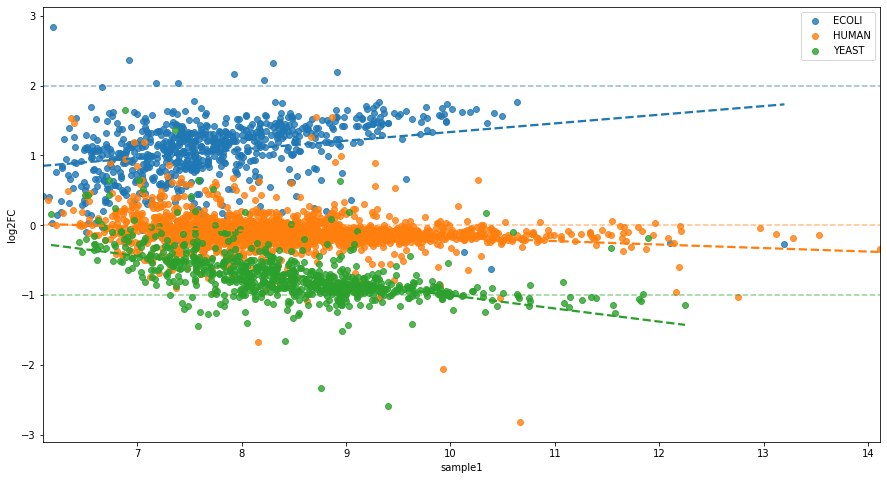

In [325]:

f, ax = plt.subplots(1, 1, figsize = (15,8))
#sns.scatterplot(ax = ax, data = df_triq, x = "log2(mu_sample2)", y = "log2_fold_change", alpha = 0.7, hue = "specie")
sns.regplot(data = 1*msrob_df[msrob_df.specie == "ECOLI"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*msrob_df[msrob_df.specie == "HUMAN"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*msrob_df[msrob_df.specie == "YEAST"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax.legend()
ax.axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax.axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax.axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
#ax.set_ylim([-5, 3])
#ax.set_xlim([-2, 1])

In [326]:
msstat_sum = msstat_protein.groupby(["Protein", "GROUP_ORIGINAL"]).LogIntensities.mean()


In [327]:
msstat_sum_sample1 = msstat_sum[msstat_sum.index.get_level_values("GROUP_ORIGINAL") == 1].droplevel("GROUP_ORIGINAL")
msstat_sum_sample2 = msstat_sum[msstat_sum.index.get_level_values("GROUP_ORIGINAL") == 2].droplevel("GROUP_ORIGINAL")
msstat_log2 = msstat_sum_sample2 - msstat_sum_sample1

msstat_sum_sample1.name = "sample1"
msstat_sum_sample2.name = "sample2"
msstat_log2.name = "log2FC"

In [328]:
msstat_df = pd.concat([msstat_sum_sample1, msstat_sum_sample2, msstat_log2], axis = 1)
msstat_df["specie"] = msstat_df.index.map(specie_mapper)

In [329]:
msstat_df

,sample1,sample2,log2FC,specie
Protein,,,,
A0FGR8_HUMAN,3.776176,3.563588,-0.212588,HUMAN
A5YKK6_HUMAN,2.541167,2.483471,-0.057696,HUMAN
A6NDG6_HUMAN,4.027395,3.905312,-0.122083,HUMAN
A6NHR9_HUMAN,2.110683,2.341832,0.231149,HUMAN
O00115_HUMAN,5.037735,5.030598,-0.007137,HUMAN
...,...,...,...,...
Q9Y5X1_HUMAN,2.068138,1.245051,-0.823087,HUMAN
Q9Y5Y2_HUMAN,4.427887,4.411319,-0.016567,HUMAN
Q9Y606_HUMAN,3.263024,3.262430,-0.000593,HUMAN


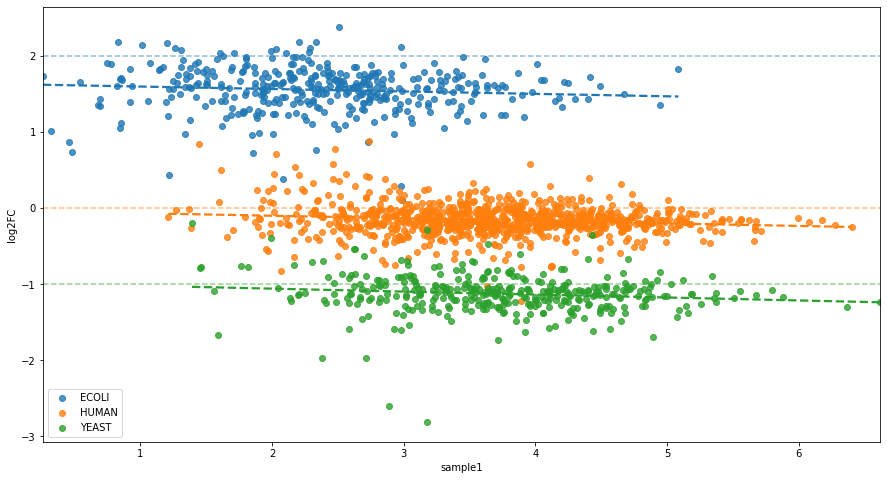

In [330]:

f, ax = plt.subplots(1, 1, figsize = (15,8))
#sns.scatterplot(ax = ax, data = df_triq, x = "log2(mu_sample2)", y = "log2_fold_change", alpha = 0.7, hue = "specie")
sns.regplot(data = 1*msstat_df[msstat_df.specie == "ECOLI"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*msstat_df[msstat_df.specie == "HUMAN"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*msstat_df[msstat_df.specie == "YEAST"], x = "sample1", y = "log2FC", ax = ax, line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax.legend()
ax.axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax.axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax.axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
#ax.set_ylim([-5, 3])
#ax.set_xlim([-2, 1])

In [331]:
df_triq["-mu_sample1"] = np.log(df_triq["mu_sample1"]).abs()
df_triq["-mu_sample1"]

df_triq["-mu_sample2"] = np.log(df_triq["mu_sample2"]).abs()
df_triq["-mu_sample2"]

0       1.223677
659     0.532783
661     0.560758
664     0.713277
665     0.441261
          ...   
935     0.308792
933     0.313798
931     0.371644
927     0.302277
2012    0.023303
Name: -mu_sample2, Length: 3153, dtype: float64

TypeError: regplot() got an unexpected keyword argument 'alpha'

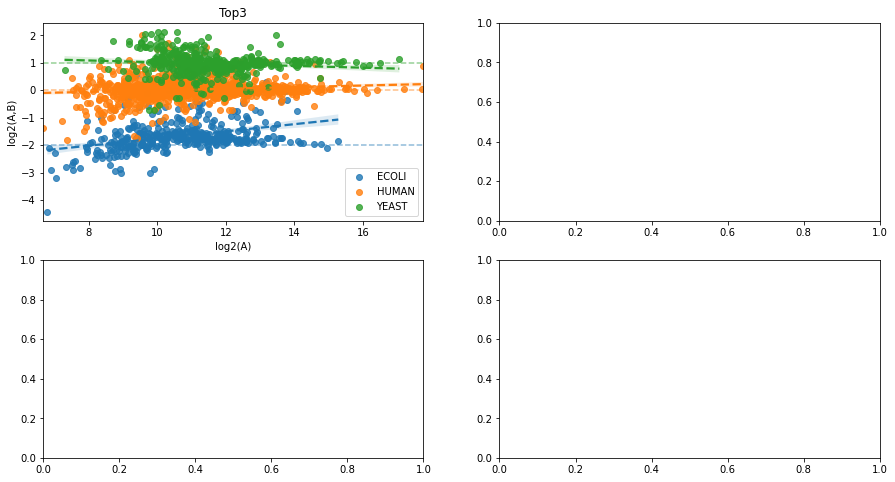

In [352]:


f, ax = plt.subplots(2, 2, figsize = (15,8))

df_final["specie"] = df_final.index.get_level_values("specie")
sns.regplot(data = df_final[df_final.specie == "ECOLI"], x = "log2(A)", y = "log2(A,B)", ax = ax[0,0], line_kws = {"ls":"--"}, label ="ECOLI")
sns.regplot(data = df_final[df_final.specie == "HUMAN"], x = "log2(A)", y = "log2(A,B)", ax = ax[0,0], line_kws = {"ls":"--"}, label = "HUMAN")
sns.regplot(data = df_final[df_final.specie == "YEAST"], x = "log2(A)", y = "log2(A,B)", ax = ax[0,0], line_kws = {"ls":"--"}, label = "YEAST")
ax[0,0].legend()
ax[0,0].axhline(1, linestyle = "--", color="tab:green", alpha = 0.5)
ax[0,0].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[0,0].axhline(-2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[0,0].set_title("Top3")

sns.regplot(data = 1*df_triq[df_triq.specie == "ECOLI"], x = "-mu_sample2", y = "-log2_fold_change", ax = ax[0,1], line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "HUMAN"], x = "-mu_sample2", y = "-log2_fold_change", ax = ax[0,1], line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*df_triq[df_triq.specie == "YEAST"], x = "-mu_sample2", y = "-log2_fold_change", ax = ax[0,1], line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax[0,1].legend()
ax[0,1].axhline(1, linestyle = "--", color="tab:green", alpha = 0.5)
ax[0,1].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[0,1].axhline(-2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[0,1].set_ylim([-4, 4])
ax[0,1].set_xlim([0, 3.5])
ax[0,1].set_title("triqler")

sns.regplot(data = 1*msrob_df[msrob_df.specie == "ECOLI"], x = "sample1", y = "log2FC", ax = ax[1,0], line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*msrob_df[msrob_df.specie == "HUMAN"], x = "sample1", y = "log2FC", ax = ax[1,0], line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*msrob_df[msrob_df.specie == "YEAST"], x = "sample1", y = "log2FC", ax = ax[1,0], line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax[1,0].legend()
ax[1,0].axhline(2, linestyle = "--", color="tab:green", alpha = 0.5)
ax[1,0].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[1,0].axhline(-1, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[1,0].set_title("msqrobsum")

sns.regplot(data = 1*msstat_df[msstat_df.specie == "ECOLI"], x = "sample1", y = "log2FC", ax = ax[1,1], line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*msstat_df[msstat_df.specie == "HUMAN"], x = "sample1", y = "log2FC", ax = ax[1,1], line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*msstat_df[msstat_df.specie == "YEAST"], x = "sample1", y = "log2FC", ax = ax[1,1], line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax[1,1].legend()
ax[1,1].axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[1,1].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[1,1].axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
ax[1,1].set_title("MSstats")

plt.suptitle("(OSW) protein level results")

In [333]:
df_final_f = df_final[df_final.q < 0.01]
#df_triq_f = df_triq[df_triq.q_value < 0.01]
#df_triq_f = df_triq[df_triq.protein_id_posterior_error_prob < 0.01]
df_triq_f = df_triq[df_triq.posterior_error_prob < 0.01]

In [334]:
msstat_df

,sample1,sample2,log2FC,specie
Protein,,,,
A0FGR8_HUMAN,3.776176,3.563588,-0.212588,HUMAN
A5YKK6_HUMAN,2.541167,2.483471,-0.057696,HUMAN
A6NDG6_HUMAN,4.027395,3.905312,-0.122083,HUMAN
A6NHR9_HUMAN,2.110683,2.341832,0.231149,HUMAN
O00115_HUMAN,5.037735,5.030598,-0.007137,HUMAN
...,...,...,...,...
Q9Y5X1_HUMAN,2.068138,1.245051,-0.823087,HUMAN
Q9Y5Y2_HUMAN,4.427887,4.411319,-0.016567,HUMAN
Q9Y606_HUMAN,3.263024,3.262430,-0.000593,HUMAN


Text(0.5, 0.98, '(OSW) protein level results')

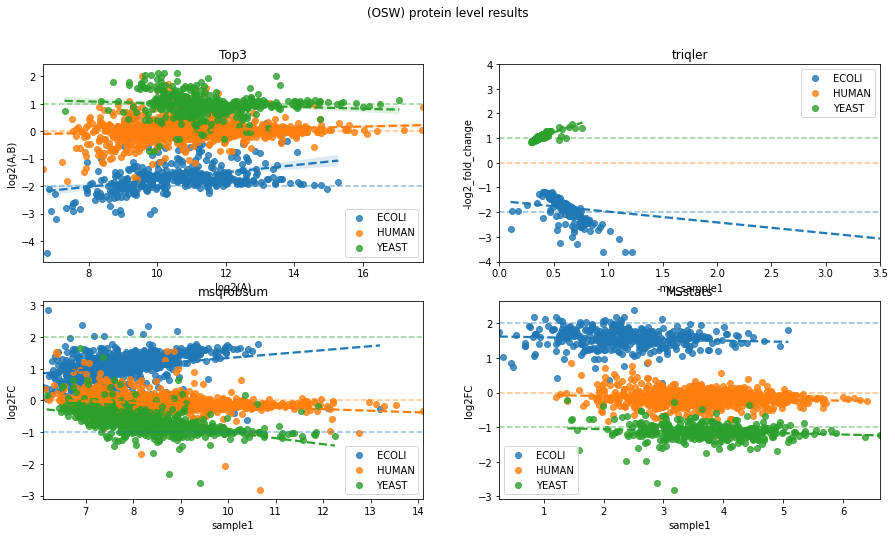

In [350]:


f, ax = plt.subplots(2, 2, figsize = (15,8))

df_final["specie"] = df_final.index.get_level_values("specie")
sns.regplot(data = df_final[df_final.specie == "ECOLI"], x = "log2(A)", y = "log2(A,B)", ax = ax[0,0], line_kws = {"ls":"--"}, label ="ECOLI")
sns.regplot(data = df_final[df_final.specie == "HUMAN"], x = "log2(A)", y = "log2(A,B)", ax = ax[0,0], line_kws = {"ls":"--"}, label = "HUMAN")
sns.regplot(data = df_final[df_final.specie == "YEAST"], x = "log2(A)", y = "log2(A,B)", ax = ax[0,0], line_kws = {"ls":"--"}, label = "YEAST")
ax[0,0].legend()
ax[0,0].axhline(1, linestyle = "--", color="tab:green", alpha = 0.5)
ax[0,0].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[0,0].axhline(-2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[0,0].set_title("Top3")

sns.regplot(data = 1*df_triq_f[df_triq_f.specie == "ECOLI"], x = "-mu_sample1", y = "-log2_fold_change", ax = ax[0,1], line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*df_triq_f[df_triq_f.specie == "HUMAN"], x = "-mu_sample1", y = "-log2_fold_change", ax = ax[0,1], line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*df_triq_f[df_triq_f.specie == "YEAST"], x = "-mu_sample1", y = "-log2_fold_change", ax = ax[0,1], line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax[0,1].legend()
ax[0,1].axhline(1, linestyle = "--", color="tab:green", alpha = 0.5)
ax[0,1].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[0,1].axhline(-2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[0,1].set_ylim([-4, 4])
ax[0,1].set_xlim([0, 3.5])
ax[0,1].set_title("triqler")

sns.regplot(data = 1*msrob_df[msrob_df.specie == "ECOLI"], x = "sample1", y = "log2FC", ax = ax[1,0], line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*msrob_df[msrob_df.specie == "HUMAN"], x = "sample1", y = "log2FC", ax = ax[1,0], line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*msrob_df[msrob_df.specie == "YEAST"], x = "sample1", y = "log2FC", ax = ax[1,0], line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax[1,0].legend()
ax[1,0].axhline(2, linestyle = "--", color="tab:green", alpha = 0.5)
ax[1,0].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[1,0].axhline(-1, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[1,0].set_title("msqrobsum")

sns.regplot(data = 1*msstat_df[msstat_df.specie == "ECOLI"], x = "sample1", y = "log2FC", ax = ax[1,1], line_kws = {"ls":"--"}, label ="ECOLI", ci = 0)
sns.regplot(data = 1*msstat_df[msstat_df.specie == "HUMAN"], x = "sample1", y = "log2FC", ax = ax[1,1], line_kws = {"ls":"--"}, label ="HUMAN", ci = 0)
sns.regplot(data = 1*msstat_df[msstat_df.specie == "YEAST"], x = "sample1", y = "log2FC", ax = ax[1,1], line_kws = {"ls":"--"}, label ="YEAST", ci = 0)
ax[1,1].legend()
ax[1,1].axhline(2, linestyle = "--", color="tab:blue", alpha = 0.5)
ax[1,1].axhline(0, linestyle = "--", color="tab:orange", alpha = 0.5)
ax[1,1].axhline(-1, linestyle = "--", color="tab:green", alpha = 0.5)
ax[1,1].set_title("MSstats")

plt.suptitle("(OSW) protein level results")

## Scaled  calibration plots 

In [336]:
os.listdir()

['msstats_input.csv',
 'msstats_run.csv',
 'msstats_input_filtered.csv',
 'msstat_output_runleveldata.csv',
 'msstats_output_filtered_.csv',
 'msstats_output_filtered.csv',
 'msstats.log']

In [337]:
os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/triqler_results")


In [338]:

def get_pq_data_triqler(q_val):
    fc_tresh = []
    n_hs = []
    n_ye = []
    n_ec = []
    ecoli_scaling_factor = []
    yeast_scaling_factor = []
    human_scaling_factor = []
    for file in sorted(os.listdir()):       
        fc = float(file.split("_")[1])
        df_triq = parse_triqler(file)
        df_triq["specie"] = df_triq.protein.map(specie_mapper)
        ecoli_factor = (df_triq["specie"] == "ECOLI").sum()/(df_triq["specie"] == "HUMAN").sum()
        yeast_factor = (df_triq["specie"] == "YEAST").sum()/(df_triq["specie"] == "HUMAN").sum()
        human_factor = (df_triq["specie"] == "HUMAN").sum()/(df_triq["specie"] == "HUMAN").sum()
        df_triq = df_triq[df_triq.q_value < q_val]
        n_hs.append((df_triq["specie"] == "HUMAN").sum())
        n_ye.append((df_triq["specie"] == "YEAST").sum())
        n_ec.append((df_triq["specie"] == "ECOLI").sum())
        ecoli_scaling_factor.append(ecoli_factor) #Should be same for all values because we want the full length of protein list
        yeast_scaling_factor.append(yeast_factor) #Should be same for all values because we want the full length of protein list
        human_scaling_factor.append(human_factor)
        fc_tresh.append(fc)
    
    df =pd.DataFrame(np.array([n_hs, n_ye, n_ec,
                               human_scaling_factor, yeast_scaling_factor, ecoli_scaling_factor]).T, index = fc_tresh, columns = ["HUMAN", "YEAS8", "ECOLI", "HUMAN_factor", "YEAS8_factor", "ECOLI_factor"])
    return df

def map_decoy(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False

#start = time.time()
def get_DE_for_fcs(fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    qs = []
    dfs = []
    for q in np.arange(0,0.101, 0.001):
        qs.append(q)
        dfs.append(get_pq_data_triqler(q))
        #print(time.time()-start)
    end = time.time()
    #print(end-start)
    
    fcs = fcs
    fcs.sort()
    res = []
    for fc in fcs:
        vals = []
        for df in dfs:
            #print(df)
            try:
                val = list(df[df.index == fc].values[0])
            except:
                print(df)
                break
            vals.append(val)    
        df_res = pd.DataFrame(vals, index = np.arange(0,0.101, 0.001), columns = ["HUMAN", "YEAST", "ECOLI", "HUMAN_factor", "YEAST_factor", "ECOLI_factor"])
        res.append(df_res)
    return res

res = get_DE_for_fcs( fcs = fcs)


In [339]:
def get_top3_factor(specie):
    return len(df_final[df_final.index.get_level_values("specie") == specie])/len(df_final[df_final.index.get_level_values("specie") == "HUMAN"])

#triqler_factor() # contained in res from get_DE_for_fcs - triqler read-in funciton

def get_msstat_factor(specie):
    return len(ms[ms["specie"] == specie]) / len(ms[ms["specie"] == "HUMAN"])  

def get_msqrob_factor(specie):
    return len(msqrob[msqrob["specie"] == specie]) / len(msqrob[msqrob["specie"] == "HUMAN"])

In [340]:
res = get_DE_for_fcs( fcs = [fc])

In [343]:

def scaled_FP_DE_plot(axs, col, fc, specie):
    top3_factor = get_top3_factor(specie)
    msstat_factor = get_msstat_factor(specie)
    msqrob_factor = get_msqrob_factor(specie)

    
    if specie == "all":
        top3_factor =  get_top3_factor("HUMAN") + get_top3_factor("ECOLI") + get_top3_factor("YEAST")
        msstat_factor = get_msstat_factor("HUMAN") + get_msstat_factor("ECOLI") + get_msstat_factor("YEAST")
        msqrob_factor = get_msqrob_factor("HUMAN") + get_msqrob_factor("ECOLI") + get_msqrob_factor("YEAST")


        df = ((pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
              pq_data(df_final, fc_treshold = fc))) * (top3_factor)
        df_triq = ((res[0]["HUMAN"] / 
                   res[0].sum(axis=1))) * (res[0]["HUMAN_factor"]+res[0]["ECOLI_factor"] +res[0]["YEAST_factor"] )
        df_ms = ((msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                 msstats_pq_data(ms, fc = fc))) * msstat_factor
        df_msqrob = ((msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                     msqrob_pq_data(msqrob, fc = fc))) * msqrob_factor        
    else:
        df = ((pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
              pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc))) * top3_factor
        df_triq = ((res[0]["HUMAN"] / 
                   res[0][specie])) * res[0][specie + "_factor"]
        df_ms = ((msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                 msstats_pq_data(ms[ms.specie == specie], fc = fc))) * msstat_factor
        df_msqrob = ((msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                     msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc))) * msqrob_factor   

    df_triq.plot(ax = axs[col], style = "b") # triqler data plot
    axs[col].plot(df.index, df.DE, "m") # plot osw top3
    axs[col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
    axs[col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob

    axs[col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
    #axs[row, col].set_title(f"fc = {fc}")
    #axs[row, col].set_xlabel("q-value")
    #axs[row, col].set_ylabel("ratio FP/DE - Differentially expressed.")

    def abline(slope, intercept, col):
        """Plot a line from slope and intercept"""
        axes = plt.gca()
        x_vals = np.array(axs[col].get_xlim())
        y_vals = intercept + slope * x_vals
        axs[col].plot(x_vals, y_vals, 'k--', alpha = 0.7)
    abline(1,0,col)

Text(0.5, 0.98, '(OSW) scaled Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

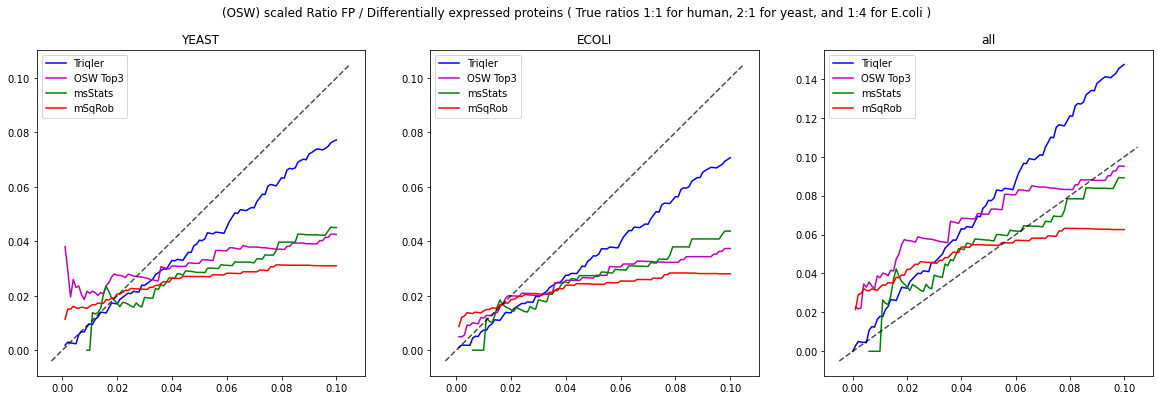

In [349]:
fig, axs = plt.subplots(1, 3, figsize=(20,6))
#scaled_FP_DE_plot(axs, row = 0, col = 0, fc = 0.4, specie = "HUMAN")
#axs[0,0].set_title("HUMAN")
scaled_FP_DE_plot(axs, col = 0, fc = 0.4, specie = "YEAST")
axs[0].set_title("YEAST")
scaled_FP_DE_plot(axs, col = 1, fc = 0.4, specie = "ECOLI")
axs[1].set_title("ECOLI")
scaled_FP_DE_plot(axs, col = 2, fc = 0.4, specie = "all")
axs[2].set_title("all")
plt.suptitle(f"(OSW) scaled Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)


In [ ]:
# make the plot for msstats [x] 
# double check triqler [x]

# Filter on scatterplot
# Mu_sample1 is transformed with some log-thing, can we re-transform it.
# Do the remapping of FDR
# Make DIANN
# Write
# Bigger font size
# Do Encyclopedia